# Outline

1. [Notebook setup](#setup)
2. [Similarity scoring](#similarity_scoring)
3. [Model implementations](#models)
4. [Metrics](#eval_metrics)
5. [Model evaluation](#eval_model)
6. [Visualisations](#visual)
7. [Other](#other)
8. [AI Policy](#ai_policy)

_Note: these internal links might not work on VSCode, but they work when using a local Jupyter Notebook session_

<h1>Setup<a id="setup"></a></h1>
This notebook was made on Python 3.11.5, so any Python version that is in the 3.11 family should work without any package conflicts.

In [1]:
%pip install numpy -q
%pip install pandas -q
%pip install scikit-learn -q
%pip install torch -q
%pip install transformers -q
%pip install gensim -q
%pip install -U sentence-transformers -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import numpy as np
import torch

from collections import defaultdict
from torch.nn import CosineSimilarity

path_data = "Data/"

!bash downloads.bash $path_data

print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
Updated Git hooks.
Git LFS initialized.
The data were already unpacked
Cuda available: True


In [3]:
from data_processing import *

processed_path = "Processed/"
!mkdir Processed

directive_data_main = get_text_from_xml(path_data + "DIR_EN_32002L0044.xml", data_preprocessing)
provision_data_main = get_text_from_xml(path_data + "NIM_EN.xml", data_preprocessing)

directive_data_transformer = get_text_from_xml(path_data + "DIR_EN_32002L0044.xml", data_preprocessing_transformer)
provision_data_transformer = get_text_from_xml(path_data + "NIM_EN.xml", data_preprocessing_transformer)

labels = json.load(open("labels.json", "rb"))

mkdir: cannot create directory ‘Processed’: File exists


<h1>Similarity Scoring<a id="similarity_scoring"></a></h1>

* Cosine similarity ($\textbf{D}_1, \textbf{D}_1 \in \mathbb{R}^{1\times Dim}$) $$Cos(\textbf{D}_1, \textbf{D}_2)=\frac{\textbf{D}_1\cdot \textbf{D}_2}{\|\textbf{D}_1\|\cdot\|\textbf{D}_2\|}$$
* Euclidean distance ($\textbf{D}_1, \textbf{D}_2 \in \mathbb{R}^{1\times Dim}$) $$E(\textbf{D}_1, \textbf{D}_2)=\sqrt{\sum_{d=1}^{Dim}(x_{d}^{D_2}-x_{d}^{D_1})^2} \newline \text{or} \newline E(\textbf{D}_1, \textbf{D}_2)=\|\textbf{D}_1-\textbf{D}_2\|$$
* Jaccard scoring ($D_1, D_2$ are sets of words) $$J(D_1, D_2)=\frac{|D_1 \cap D_2|}{|D_1 \cup D_2|}$$

In [4]:
cos = CosineSimilarity(dim = 0)

def cosine_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the cosine similarity between 2 given tensors. Values are in the interval  [-1,1].
    """
    return cos(x, y)

def euclidean_distance(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the Euclidean distance between 2 given tensors. Values are in the interval [0, +inf).
    """
    return torch.norm(torch.subtract(x, y))

def jaccard_score(x: set, y: set) -> float:
    """
    Find the Jaccard score between 2 sets of tokens. Values are in the interval [0,1].
    """
    return len(x & y)/len(x | y)

<h1>Models<a id="models"></a></h1>

## Doc2vec

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

training_config = {
    'vector_size': 100,
    'epochs': 1000,
    'dm_tag_count': 3,
    'dm_mean': 1,
    'alpha': 0.015,
    'workers': 10,
    'min_count': 3
}

def encode_doc2vec(x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    Encode 2 given datasets using a doc2vec model. It is trained on the directive articles, 
    after which it will predict the dense vectors of the provision articles.
    """
    training_data = x_data["Text"].to_numpy()
    test_data = y_data["Text"].to_numpy()

    # assign unique document IDs to each directive in the training corpus
    training_data = [TaggedDocument(text, [doc_id]) for doc_id, text in enumerate(training_data)]

    # train a doc2vec model on the directives to predict provision vectors
    model_doc2vec = Doc2Vec(**training_config)
    model_doc2vec.build_vocab(training_data)
    model_doc2vec.train(training_data, total_examples = model_doc2vec.corpus_count, epochs = model_doc2vec.epochs)

    x_data["Encoded_Text"] = [model_doc2vec.dv[idx] for idx in range(len(model_doc2vec.dv))]
    y_data["Encoded_Text"] = [model_doc2vec.infer_vector(test_sent) for test_sent in test_data]

    return x_data, y_data

## TFIDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# base bare bones tfidf no stop words; the data were processed manually
tfidf_model = TfidfVectorizer(stop_words = None, lowercase = False, binary = True)

def encode_tfidf(x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    Encode 2 given datasets using a tfidf model. It builds a corpus based on directive articles and creates 
    their corresponding sparse representations. The provision articles will also be transformed to sparse 
    representations, using the previously defined model.
    """
    x_texts = [" ".join(text[:]) for text in x_data["Text"]]
    y_texts = [" ".join(text[:]) for text in y_data["Text"]]

    x_encoded = tfidf_model.fit_transform(x_texts).toarray()
    y_encoded = tfidf_model.transform(y_texts).toarray()

    x_data["Encoded_Text"] = list(x_encoded)
    y_data["Encoded_Text"] = list(y_encoded)

    return x_data, y_data

## Transformer embeddings - BERT (English, base, uncased)

In [7]:
from transformers import BertTokenizer, BertModel

model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model_transformer = BertModel.from_pretrained(model_name).to(device) # cast to cuda/cpu device, whichever is avaiable

In [8]:
from transformers import BatchEncoding

def encode_sentence_transformer(sentence: list) -> np.ndarray:
    """
    Given a list of tokens, compute its dense vector using a BERT model. The resulting 512 tokens are mean-pooled, 
    taking into consideration their presence in the attention mask.
    """
    sentence = " ".join(sentence)
    tokenized_sentence = tokenizer(sentence, max_length = 512, padding = "max_length", truncation = True, return_tensors = "pt", return_attention_mask = True)
    
    # cast all tensors to the same device -> speeds up prediction time and any subsequent computations
    aux = {}
    for key, value in tokenized_sentence.items():
        aux[key] = value.to(device)
    tokenized_sentence = BatchEncoding(aux)
    
    model_output = model_transformer(**tokenized_sentence)

    # pool the values of the last hidden state using a weighted averaged that ignores all tokens with 0 in the attention mask
    last_hidden_state = model_output.last_hidden_state[0]
    attention_mask = tokenized_sentence.attention_mask[0]
    attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    data_attention = last_hidden_state * attention_mask
    sentence_vector = torch.sum(data_attention, 0)/torch.clamp(attention_mask.sum(0), min = 1e-9)

    return np.array(sentence_vector.cpu().detach().numpy())

def encode_transformer(data: pd.DataFrame) -> pd.DataFrame:
    """
    Encode all data from a dataset using a BERT model.
    """
    data["Encoded_Text"] = data["Text"].apply(encode_sentence_transformer)

    return data


## Sentence Transformer

In [9]:
from sentence_transformers import SentenceTransformer

model_sentence = SentenceTransformer("all-distilroberta-v1").to(device)

In [10]:
def encode_sentence_stransformer(sentence: list) -> torch.Tensor:
    """
    Compute the encoding of a sentence using a transformer model trained on a sentence similarity task.
    """
    return model_sentence.encode(" ".join(sentence))

def encode_stransformer(data: pd.DataFrame) -> pd.DataFrame:
    """
    Encode all data from a dataset using a sentence transformer model.
    """
    data["Encoded_Text"] = data["Text"].apply(encode_sentence_stransformer)

    return data

<h1>Evaluation metrics<a id="eval_metrics"></a></h1>

* $P = \frac{TP}{TP+FP}$
* $R = \frac{TP}{TP+FN}$
* $F_1 = \frac{2\cdot P\cdot R}{P+R}$

The confusion matrix from which the above values are used is computed per class (i.e. per provision label). The three used metrics are then aggregated using 4 different appoaches (macro, micro, sample, and weighted averaging), which will be all displayed in a plot in the [Visualisation](#visual) section.

In [11]:
def compute_similarity(directive_data: pd.DataFrame, provision_data: pd.DataFrame, similarity_function: callable, threshold: float|int = 1, top_n: int = 3) -> list:
    """
    Compute the similarity between directives and provisions and choose the top n most similar documents that pass a threshold
    """
    
    if similarity_function == jaccard_score: # jaccard scoring requires sets of words not numerical vectors, hence the separate if conditional
        dir_matrix = directive_data.copy()["Text"].apply(lambda x: set(x)).to_numpy()
        pro_matrix = provision_data.copy()["Text"].apply(lambda x: set(x)).to_numpy()
    else:
        # this notation is rather cumbersome, but directly obtaining a numpy ndarray from pandas yields an array with a missing second dimension for some reason, so this is a workaround
        dir_matrix = torch.from_numpy(np.asarray(directive_data["Encoded_Text"].tolist(), dtype=float))
        pro_matrix = torch.from_numpy(np.asarray(provision_data["Encoded_Text"].tolist(), dtype=float))

    # compare each directive document with each provision document, and select the top n documents that pass a threshold
    labels_pred = defaultdict()
    for id, doc1 in zip(directive_data["ID"], dir_matrix):
        scores = []
        for doc2 in pro_matrix:
            score = similarity_function(doc1, doc2)
            scores.append(score.item() if torch.is_tensor(score) else score)

        scores = np.asarray(scores)

        # euclidean similarity, the lower the distance the more similar it is
        if similarity_function != cosine_similarity and similarity_function != jaccard_score:
            threshold_check = lambda x: x >= threshold
            best_idx = np.argsort(scores)[::][:top_n]
        else: # both jaccard and cosine require the scores to be as high as possible
            threshold_check = lambda x: x < threshold
            best_idx = np.argsort(scores)[::-1][:top_n]

        # remove those documents from the chosen n that don't fulfill the threshold
        idx = 0
        aux = []
        while idx < len(best_idx):
            if threshold_check(scores[best_idx[idx]]):
                break
            aux.append(best_idx[idx])
            idx += 1
        best_idx = aux

        # a directive can only be null when it has no other labels
        label = provision_data.iloc[best_idx]["ID"].to_list() if len(best_idx) > 0 else ["Null"]
        labels_pred[id] = label

    return labels_pred

In [12]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

def binarize_labels(input_labels: list, true_labels: list) -> np.ndarray:
    """
    Convert labels from string IDs to binary representations for multi-label classification.

    e.g. go from [[1, 2, 0], [1, 3, 2], [2, 0, 3]] to [[1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 1, 1]].
    """

    # obtain all unique provision labels, including null
    true_labels = [label for labels in true_labels for label in labels]
    true_labels.sort()
    true_labels = sorted(set(true_labels), key=true_labels.index)

    # convert the input labels to their binary representation
    binary_labels = []
    for input_ids in input_labels:
        binary_ids = []
        for id in true_labels:
            binary_ids.append(int(id in input_ids))

        binary_labels.append(binary_ids)

    return np.asarray(binary_labels)

def evaluation(predicted_labels: defaultdict, true_labels: defaultdict) -> (dict, np.ndarray):
    """
    Evalute the obtained predicted labels with the ground truth
    """
    true_binary = binarize_labels(list(true_labels.values()), list(true_labels.values()))
    predicted_binary = binarize_labels(list(predicted_labels.values()), list(true_labels.values()))

    results = classification_report(true_binary, predicted_binary, output_dict = True, zero_division = 0) # precision + recall + f1 
    confusion_matrix = multilabel_confusion_matrix(true_binary, predicted_binary)

    return results, confusion_matrix

<h1>Evaluation of Models<a id="eval_model"></a></h1>

In [13]:
def encode(encoding_method: callable, x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    Wrapper function for data encoding.
    """
    if encoding_method in (encode_tfidf, encode_doc2vec): # these methods require both the training and label data at once, hence the conditional
        x_data, y_data = encoding_method(x_data, y_data)
    else:
        x_data = encoding_method(x_data)
        y_data = encoding_method(y_data)
    
    return x_data, y_data


def predict(x_data: pd.DataFrame, y_data: pd.DataFrame, **kwargs) -> defaultdict:
    """
    Wrapper function for prediction labels.
    """
    return compute_similarity(x_data, y_data, kwargs["similarity_function"], kwargs["threshold"], kwargs["top_n"])


In [40]:
# the threhsold values in the inner dictionaries were chosen based on trial and error
evaluation_pairs = {
    "Jaccard Scoring": (None, {"jaccard": 0.21}),
    "TF-IDF": (encode_tfidf, {"cosine": 0.2, "euclidean": 1.1}),
    "Transformer": (encode_transformer, {"cosine": 0.89, "euclidean": 2.6}),
    "Sentence Transformer": (encode_stransformer, {"cosine": 0.7, "euclidean": 0.9}),
    "Doc2vec": (encode_doc2vec, {"cosine": 0.46, "euclidean": 14})
}

similarity_functions = {"cosine": cosine_similarity, "euclidean": euclidean_distance, "jaccard": jaccard_score}
scores = defaultdict(dict)
model_predicted_labels = defaultdict(dict)
for method, (encoding_method, thresholds) in evaluation_pairs.items():
    print(method)
    directive_data, provision_data = (directive_data_transformer, provision_data_transformer) \
        if encoding_method == encode_stransformer else (directive_data_main, provision_data_main)
    
    if encoding_method != None: # jaccard scoring does not require encoding
        directive_data, provision_data = encode(encoding_method = encoding_method, x_data = directive_data, y_data = provision_data)

    for similarity_name, similarity_function in similarity_functions.items():
        if similarity_name not in thresholds.keys(): # skip over cosine and euclidean scoring for jaccard
            continue

        predicted_labels = predict(directive_data, provision_data, similarity_function = similarity_function, threshold = thresholds[similarity_name], top_n = 3)
        metrics = evaluation(predicted_labels, labels)

        scores[method][similarity_name] = metrics
        model_predicted_labels[method][similarity_name] = predicted_labels

Jaccard Scoring
TF-IDF
Transformer
Sentence Transformer
Doc2vec


## Predicted labels

In [72]:
def create_dataframe_labels(model_predicted_labels: dict, true_labels:dict, used_models: list, similarity_function: str) -> pd.DataFrame:
    directive_names = list(true_labels.keys())

    predicted_labels = [directive_names]

    for model in used_models:
        scoring = similarity_function if similarity_function in model_predicted_labels[model].keys() else "jaccard"
        lab = list(model_predicted_labels[model][scoring].values())
        lab = [", ".join(l) for l in lab]
        predicted_labels.append(lab)

    df_pred_labels = pd.DataFrame(predicted_labels).T
    df_pred_labels.columns = ["Directive"] + used_models
    df_pred_labels = df_pred_labels.set_index("Directive")
    
    return df_pred_labels

In [73]:
create_dataframe_labels(model_predicted_labels, labels, list(evaluation_pairs.keys()), "cosine")

,Jaccard Scoring,TF-IDF,Transformer,Sentence Transformer,Doc2vec
Directive,,,,,
A1_1,P3,"P3, P5_1",P8_1,"P7, P3, P5_4",P3
A1_2,"P3, P5_1","P3, P5_1","P3, P5_1, P6_4","P3, P7, P6_4",P3
A1_3,Null,P8_1,Null,Null,P5_3
A2,P2,P2,P2,Null,P5_4
A3_1,"P4_1, P4_2","P4_1, P4_2, P2","P4_1, P4_2","P4_1, P4_2","P4_1, P4_2"
A3_2,"P4_2, P4_1","P4_2, P4_1","P4_2, P4_1","P4_2, P4_1, P5_4","P4_2, P4_1"
A4_1,"P5_1, P5_2","P5_2, P5_1, P8_1","P5_2, P9_1, P5_5","P5_1, P7, P5_2",P4_1
A4_2,"P5_2, P5_4","P5_2, P5_4, P7","P5_2, P5_4, P7","P5_2, P7, P5_1","P5_2, P5_4"
A4_3,P5_3,"P5_3, P5_6, P8_3","P5_2, P10_1, P5_3","P5_2, P7, P5_1","P5_6, P5_3"


In [74]:
create_dataframe_labels(model_predicted_labels, labels, list(evaluation_pairs.keys()), "euclidean")

,Jaccard Scoring,TF-IDF,Transformer,Sentence Transformer,Doc2vec
Directive,,,,,
A1_1,P3,P3,Null,"P7, P3, P5_4","P3, P6_4, P5_3"
A1_2,"P3, P5_1",P3,Null,"P3, P7, P6_4","P3, P6_4, P5_3"
A1_3,Null,Null,Null,Null,"P5_3, P6_4, P3"
A2,P2,P2,Null,"P2, P7, P3","P6_4, P3, P4_1"
A3_1,"P4_1, P4_2","P4_1, P4_2",P4_1,"P4_1, P4_2, P2","P4_1, P4_2, P6_4"
A3_2,"P4_2, P4_1","P4_2, P4_1",Null,"P4_2, P4_1, P5_4","P4_2, P4_1, P5_3"
A4_1,"P5_1, P5_2",Null,Null,"P5_1, P7, P5_2","P5_3, P4_1, P6_4"
A4_2,"P5_2, P5_4",P5_2,Null,"P5_2, P7, P5_1","P5_2, P6_4, P5_3"
A4_3,P5_3,P5_3,Null,"P5_2, P7, P5_1","P5_3, P5_6, P6_4"


<h1>Visualisation of Results<a id="visual"></a></h1>

In [15]:
avg_methods = ["micro avg", "macro avg", "samples avg", "weighted avg"]

all_scores = []
similarity_functions = ["jaccard", "cosine", "euclidean"]
for encoding in evaluation_pairs.keys():
    if encoding == "Jaccard Scoring":
        similarity = similarity_functions[:1]
    else:
        similarity = similarity_functions[1:]
    
    for sim in similarity:
        # a placeholder dictionary to counteract the fact that most models don't use all scoring methods
        score_dictionary = {"Encoding": [encoding.replace(" ", "\n")] * 4 * 3, "Similarity": [sim] * 4 * 3, "AVG": [], "Metric": [], "Score": []}
        metrics = scores[encoding][sim][0] # choose classification report
        for avg in avg_methods:
            metric_keys = list(metrics[avg].keys())[:-1]
            score_values = [round(metrics[avg][metric], 3) for metric in metric_keys]
            score_dictionary["AVG"] += [avg] * 3
            for metric, value in zip(metric_keys, score_values):
                score_dictionary["Metric"] += [metric]
                score_dictionary["Score"] += [value]

        score_df = pd.DataFrame(score_dictionary)
        all_scores.append(score_df)

all_scores = pd.concat(all_scores)
all_scores

,Encoding,Similarity,AVG,Metric,Score
0,Jaccard\nScoring,jaccard,micro avg,precision,0.738
1,Jaccard\nScoring,jaccard,micro avg,recall,0.816
2,Jaccard\nScoring,jaccard,micro avg,f1-score,0.775
3,Jaccard\nScoring,jaccard,macro avg,precision,0.660
4,Jaccard\nScoring,jaccard,macro avg,recall,0.796
...,...,...,...,...,...
7,Doc2vec,euclidean,samples avg,recall,0.468
8,Doc2vec,euclidean,samples avg,f1-score,0.311
9,Doc2vec,euclidean,weighted avg,precision,0.490
10,Doc2vec,euclidean,weighted avg,recall,0.447


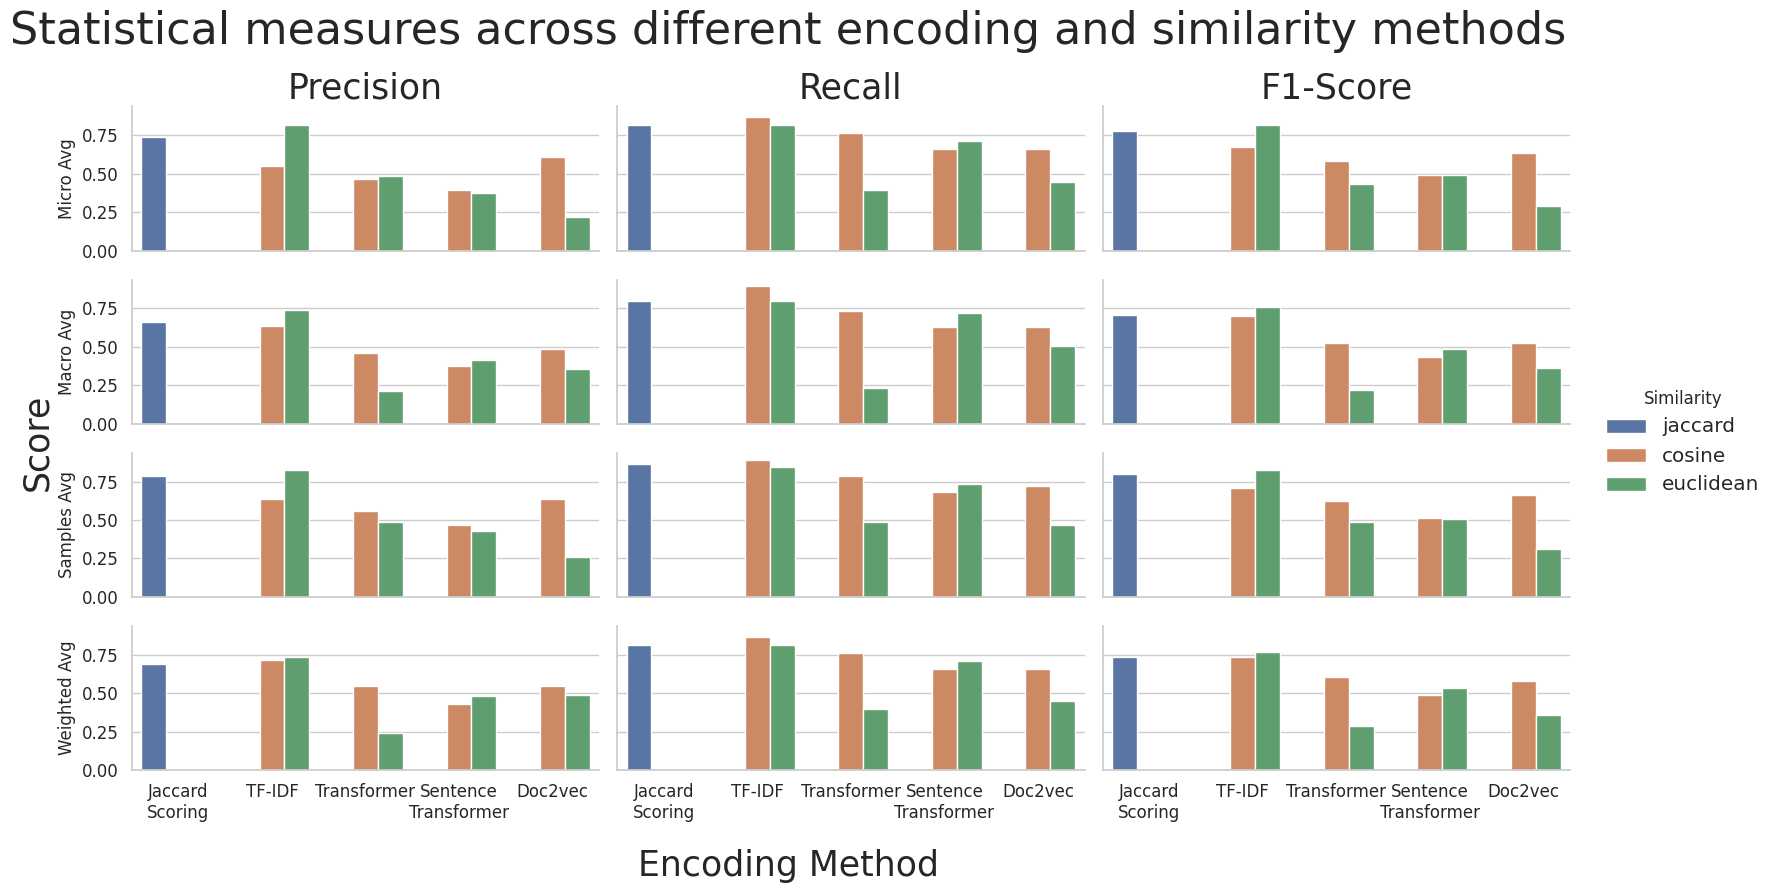

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

# many auxiliary commands to create a custom plot to determine the plot's shape, labels, and values across all metrics and models

sns.set_theme(context = "notebook", style = "whitegrid")

fig, axes = plt.subplots(4, 3, figsize = (16,9), sharex = True, sharey = True)
axes = axes.T
metric_order = ["precision", "recall", "f1-score"]

legend_not_set = True
labels_plot = ""
plot = ""
for ax_column, metric in zip(axes, metric_order):
    metric_set = False
    for ax, avg in zip(ax_column, avg_methods):
        aux_data = all_scores[(all_scores["AVG"] == avg) & (all_scores["Metric"] == metric)]
        plot = sns.barplot(data = aux_data, x = "Encoding", y = "Score", hue = "Similarity", ax = ax, legend = True)
        ax.legend().remove()
        legend_not_set = False
        ax.set_title(metric.title(), fontsize=25) if not metric_set else 1
        metric_set = True
        ax.set_xlabel("")
        ax.set_ylabel(avg.title()) if metric == "precision" else 1
        ax.tick_params(labelsize = 12)

fig.suptitle("Statistical measures across different encoding and similarity methods", fontsize = 32)
fig.supxlabel("Encoding Method", fontsize = 25)
fig.supylabel("Score", fontsize = 25)
plt.tight_layout()
handles, labels_legend = ax.get_legend_handles_labels()
plt.figlegend(handles, labels_legend, loc = 'center left', bbox_to_anchor = (1, 0.5), title = "Similarity", fontsize = "large", frameon = False)
sns.despine()

plt.show()

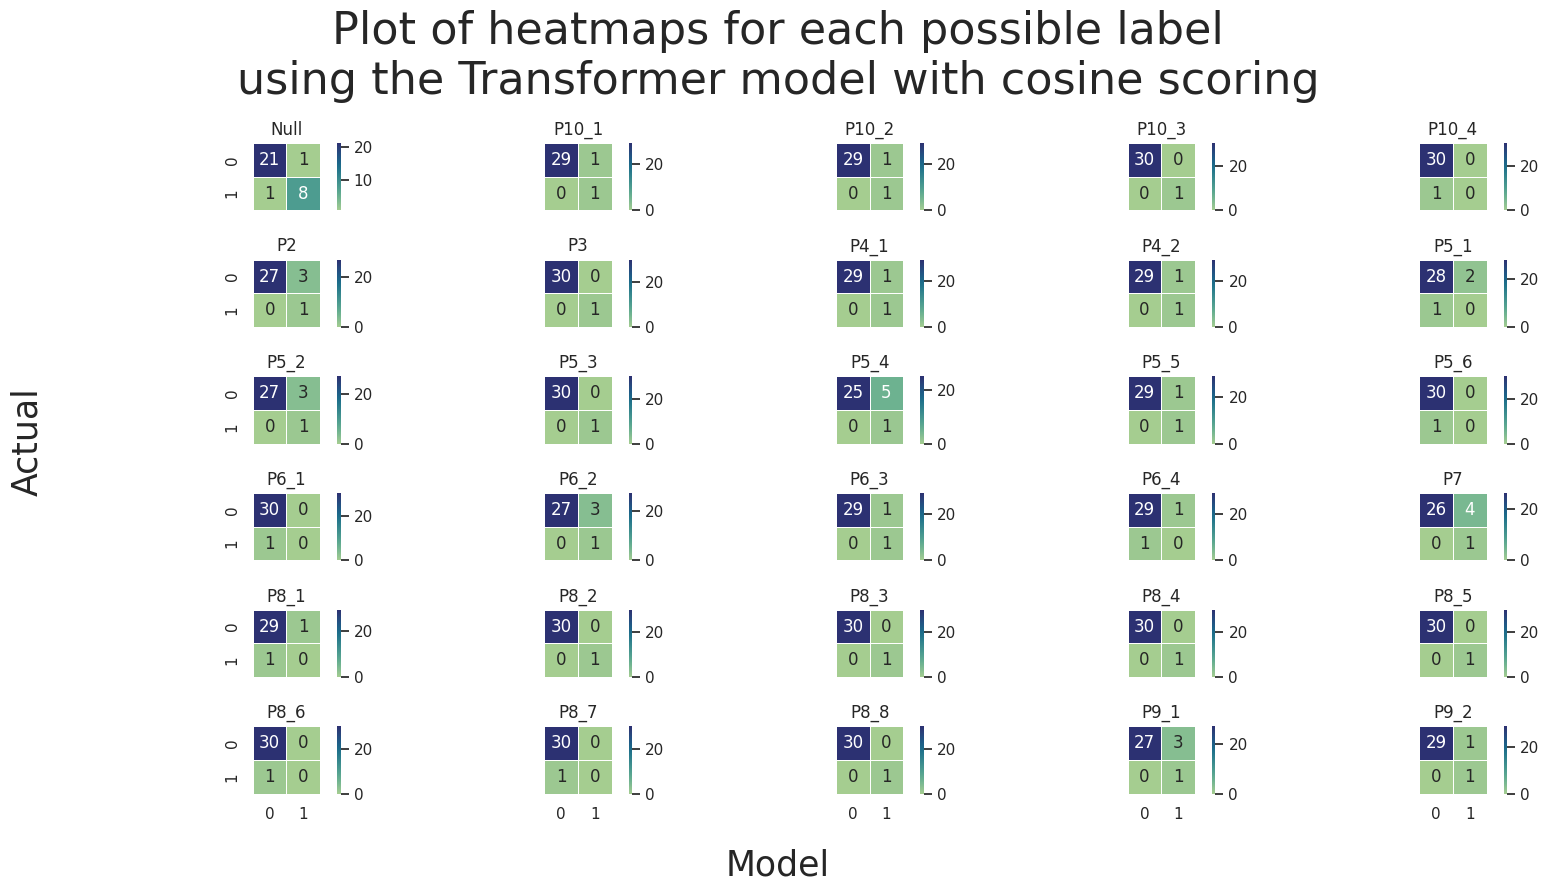

In [17]:
sns.set_theme(context="notebook")

unique_labels = labels
unique_labels = list(unique_labels.values())
unique_labels = [label for ls in unique_labels for label in ls]
unique_labels.sort()
unique_labels = sorted(set(unique_labels), key=unique_labels.index)

fig, axes = plt.subplots(6, 5, figsize=(16,9), sharex=True, sharey=True)
axes = axes.reshape(-1)

model_name_heatmap = "Transformer"
similarity_name_heatmap = "cosine"

# example multi-heatmap plot for BERT with mean-pooling using cosine similarity
for ax, label, matrix in zip(axes, unique_labels, scores[model_name_heatmap][similarity_name_heatmap][1]):
    sns.heatmap(matrix, ax = ax, annot = True, square = True, linewidth = 0.5, cmap = "crest")
    ax.set_title(label)

fig.suptitle(f"Plot of heatmaps for each possible label\nusing the {model_name_heatmap} model with {similarity_name_heatmap} scoring", fontsize = 32)
fig.supxlabel("Model", fontsize = 25)
fig.supylabel("Actual", fontsize = 25)
plt.tight_layout()
plt.show()

<h1>Other<a id="other"></a></h1>

Here is the code that was used to find the most optimal hyperparameters for doc2vec. It is a naive, brute search approach that tries every possible parameter combination

In [18]:
import itertools
from tqdm import tqdm

def encode_doc2vec_search(x_data: pd.DataFrame, y_data: pd.DataFrame, config: dict) -> (pd.DataFrame, pd.DataFrame):
    """
    Same as the standard doc2vec training procedure, though this time the function will receive different training configurations across multiple runs
    """
    training_data = x_data["Text"].to_numpy()
    test_data = y_data["Text"].to_numpy()

    training_data = [TaggedDocument(text, [doc_id]) for doc_id, text in enumerate(training_data)]

    model_doc2vec = Doc2Vec(**config)
    model_doc2vec.build_vocab(training_data)
    model_doc2vec.train(training_data, total_examples = model_doc2vec.corpus_count, epochs = model_doc2vec.epochs)

    x_data["Encoded_Text"] = [model_doc2vec.dv[idx] for idx in range(len(model_doc2vec.dv))]
    y_data["Encoded_Text"] = [model_doc2vec.infer_vector(test_sent) for test_sent in test_data]

    return x_data, y_data

def search_doc2vec_parameter_space(search_space: dict) -> pd.DataFrame:
    """
    Search through the entire parameter space defined by the user
    """
    thresholds = {"cosine": 0.46, "euclidean": 15}

    keys, values = zip(*search_space.items())
    doc2vec_scores = {"F1": [], "Config": []}
    for v in tqdm(itertools.product(*values)):
        training_config = dict(zip(keys, v))

        similarity_functions = {"cosine": cosine_similarity}
        directive_data, provision_data = directive_data_main, provision_data_main
        directive_data, provision_data = encode_doc2vec_search(x_data = directive_data, y_data = provision_data, config = training_config)

        for similarity_name, similarity_function in similarity_functions.items():
            predicted_labels = predict(directive_data, provision_data, similarity_function = similarity_function, threshold = thresholds[similarity_name], top_n = 3)
            metrics = evaluation(predicted_labels, labels)

            doc2vec_scores["F1"] += [metrics[0]["micro avg"]["f1-score"]]
            doc2vec_scores["Config"] += [training_config]

    return pd.DataFrame(doc2vec_scores)

In [19]:
search_paramters = False # change to True if you want to search through all parameters

if search_paramters:
    search_space = {
        "vector_size": [100, 256, 512, 768],
        "epochs": [100, 200, 400, 800, 1000],
        "dm_tag_count": [3],
        "dm_mean": [1],
        "alpha": [0.01, 0.015, 0.02, 0.025],
        "workers": [10],
        "min_count": [3, 5, 7]
    }
    
    doc2vec_scores = search_doc2vec_parameter_space(search_space)
    max_f1_score = doc2vec_scores["F1"].max()
    print(doc2vec_scores[doc2vec_scores["F1"] == max_f1_score]["Config"].item())

<h1>AI Policy<a id="ai_policy"></a></h1>

No AI generative models were used in solving this task. Every implementation was made using knowledge gained from my Bachelor's courses, using classic internet fora for debugging, and reading the documentation of the used packages.